# Dataset

#### *Dataset: It is Titanic!*
#### *Port of Registry: Liverpool, UK*
#### *Route: Southampton to New York City.*
#### *Description: The Dataset shows us which passengers survived.*<br>

##### *Columns of Dataset:*

##### *1. Survived: if the passenger survived or not (1, 0)*
##### *2. Pclass: Ticket class*
##### *3. Sex: Gender of passengers*
##### *4. Age: Age of passengers*
##### *5. Sibsp: Sieblings in Titanic*
##### *6. Parch: Parents/Children in Titanic*
##### *7. Embarked: Port of embarkation*
##### *8. Fare: Ticket price*
##### *9. Cabin: Number of cabin*

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Import Dataset & Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score,recall_score, roc_auc_score,roc_curve, plot_roc_curve

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Data Preprocessing

In [ ]:
def check_df(dataframe, head=5, tail=3):
    print("######################## Shape ########################\n")
    print(dataframe.shape)
    print("######################## Types ########################\n")
    print(dataframe.dtypes)
    print("######################## Head ########################\n")
    print(dataframe.head(head))
    print("######################## Tail ########################\n")
    print(dataframe.tail(tail))
    print("######################## NA ########################\n")
    print(dataframe.isnull().sum())
    print("\n\n######################## Quantiles ########################\n")
    print(dataframe.describe([0, 0.05, 0.25, 0.50, 0.95, 0.99]).T)

check_df(df)

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [ ]:
num_cols = [col for col in num_cols if col != "PassengerId"]
cat_cols = [col for col in cat_cols if col != "Survived"]

In [ ]:
# Categoric Columns

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
for col in cat_cols:
    cat_summary(df, col)

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(df, col))

In [ ]:
# Replace the outliers with the low and up limits on Fare Column.

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
replace_with_thresholds(df, "Fare")

In [ ]:
# Check the missing values and fill them:

df.isnull().sum()

In [ ]:
# categoric ("Embarked") filled with mode:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

# numeric ("Age") filled with median of age of gender
df["Age"] = df["Age"].fillna(df.groupby("Sex")["Age"].transform("median"))

In [ ]:
# Creating some new features:

# cabin bool
df["New_Cabin_Bool"] = df["Cabin"].notnull().astype('int')

# name count
df["New_Name_Count"] = df["Name"].str.len()

# name word count
df["New_Name_Word_Count"] = df["Name"].apply(lambda x: len(str(x).split(" ")))

# name dr
df["New_Name_Dr"] = df["Name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

# name title
df['New_Title'] = df.Name.str.extract(' ([A-Za-z]+)\. ', expand=False)

# family size
df["New_Family_Size"] = df["SibSp"] + df["Parch"] + 1

# age_pclass
df["New_Age_Pclass"] = df["Age"] * df["Pclass"]

# is alone
df.loc[((df['SibSp'] + df['Parch']) > 0), "New_Is_Alone"] = "NO"
df.loc[((df['SibSp'] + df['Parch']) == 0), "New_Is_Alone"] = "YES"

# age level
df.loc[(df['Age'] < 18), 'New_Age_Cat'] = 'young'
df.loc[(df['Age'] >= 18) & (df['Age'] < 56), 'New_Age_Cat'] = 'mature'
df.loc[(df['Age'] >= 56), 'New_Age_Cat'] = 'senior'

# sex x age
df.loc[(df['Sex'] == 'male') & (df['Age'] <= 21), 'New_Sex_Cat'] = 'youngmale'
df.loc[(df['Sex'] == 'male') & ((df['Age'] > 21) & (df['Age']) <= 50), 'New_Sex_Cat'] = 'maturemale'
df.loc[(df['Sex'] == 'male') & (df['Age'] > 50), 'New_Sex_Cat'] = 'seniormale'
df.loc[(df['Sex'] == 'female') & (df['Age'] <= 21), 'New_Sex_Cat'] = 'youngfemale'
df.loc[(df['Sex'] == 'female') & ((df['Age'] > 21) & (df['Age']) <= 50), 'New_Sex_Cat'] = 'maturefemale'
df.loc[(df['Sex'] == 'female') & (df['Age'] > 50), 'New_Sex_Cat'] = 'seniorfemale'

In [ ]:
# Describe the columns again.
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if "PassengerId" not in col]

In [ ]:
# remove columns that we don't need.
remove_cols = ["Ticket", "Name"]
df.drop(remove_cols, inplace=True, axis=1)

In [ ]:
# checking the rare values and remove them from dataset:

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if "PassengerId" not in col]
rare_analyser(df, "Survived", cat_cols)

In [ ]:
# If the ratio above under 1% and if they more than 1, we can merge them together and call as rare class. 

def rare_encoder(dataframe, rare_perc, cat_cols):
    rare_columns = [col for col in cat_cols if (dataframe[col].value_counts() / len(dataframe) < 0.01).sum() > 1]

    for col in rare_columns:
        tmp = dataframe[col].value_counts() / len(dataframe)
        rare_labels = tmp[tmp < rare_perc].index
        dataframe[col] = np.where(dataframe[col].isin(rare_labels), 'Rare', dataframe[col])

    return dataframe

df = rare_encoder(df, 0.01, cat_cols)

In [ ]:
# Let's check again the dataset with rare analyser:

rare_analyser(df, "Survived", cat_cols)

In [ ]:
# We need an encoding for the categoric columns before the modelling and use 'One Hot Encoding'
# Take the categoric columns with between 2 and 10 values, so we do also label encoding (binary columns)

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() >= 2 and col not in "Survived"]
df = one_hot_encoder(df, ohe_cols, True)

In [ ]:
df.shape

# Now, 45 columns we have.

In [ ]:
# One more! We can remove the useless columns.
# If the ratio less than 1%, we can remove it.

useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]
df.drop(useless_cols, axis=1, inplace=True)

In [ ]:
df.shape

# Just one is gone...

In [ ]:
# Okay, okay. Last move.

# standard scaler
num_cols = [col for col in num_cols if "PassengerId" not in col]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Modelling

#### Modelling with Logistic Regression

##### *Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist.*

In [ ]:
# Model

y = df["Survived"]
X = df.drop(["PassengerId", "Survived", "Cabin"], axis=1)

log_model = LogisticRegression().fit(X, y)
y_pred = log_model.predict(X)

In [ ]:
print(classification_report(y, y_pred))

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Confusion Matrix

#### What do these mean? What is F1 Score or Recall or Accuracy?
#### So, first we should understand the confusion matrix and the scores:<br>
##### Accuracy: Success rate of the prediction
##### Precision: It shows how many of those predicted as positive are successful.
##### Recall: It shows how many of the values we should have predicted positively.
##### F1 Score: It is a harmonical mean of Precision and Recall.

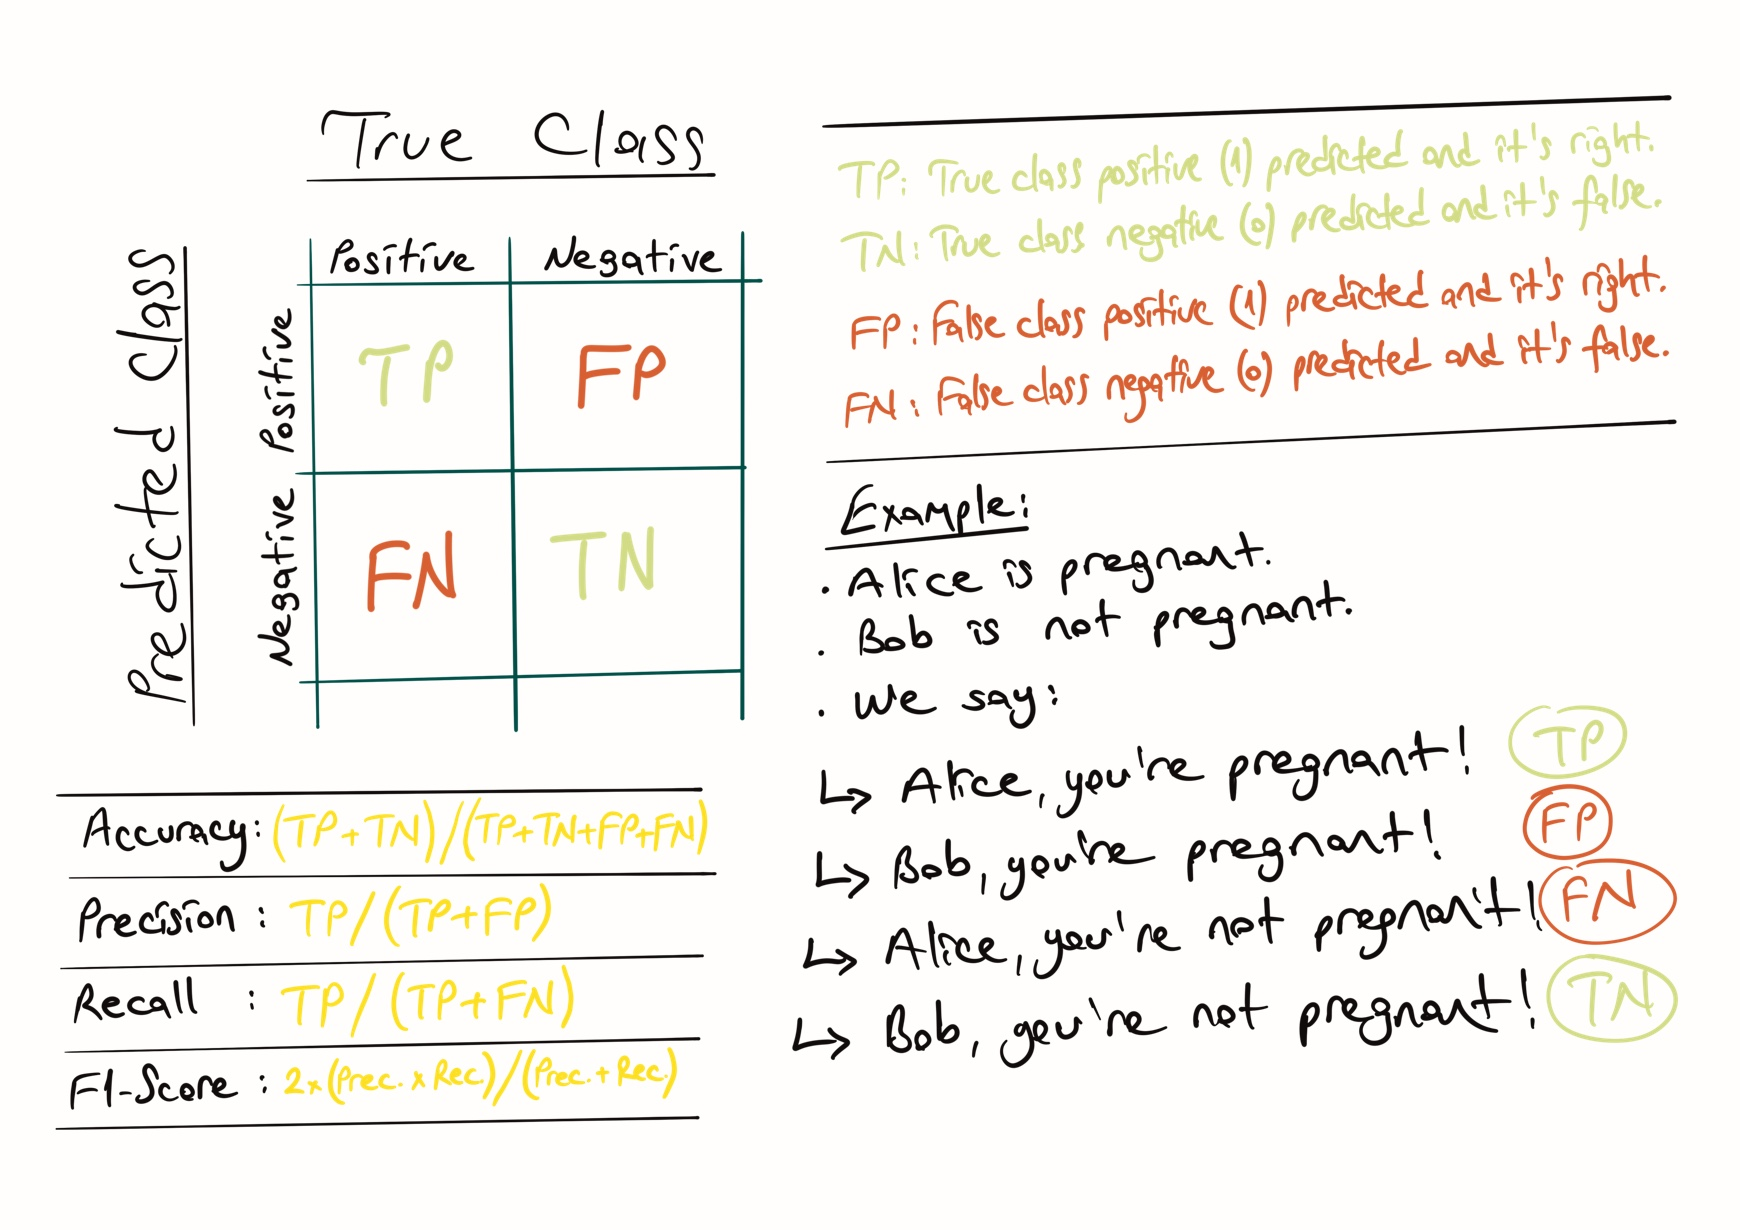

In [ ]:
# Confusion Matrix of dataset:

def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

##### AUC Score: AUC represents the probability that a random positive (green) example is positioned to the right of a random negative (red) example.<br> It measures the entire two-dimensional area under the entire ROC curve from (0,0) to (1,1). The best value is 1, the worst value is 0.5 (We will check the graphic later).

In [ ]:
y_prob = log_model.predict_proba(X)[:, 1]
print("AUC Score: " + str(roc_auc_score(y, y_prob)))

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Model Validation

In [ ]:
# Model Validation with K-Fold Cross Validate

# 80% Train, 20% Test of Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

# Train Set (cross validation: 5)
log_model = LogisticRegression().fit(X_train, y_train)
cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

# Test Set
y_pred = log_model.predict(X_test)

y_prob = log_model.predict_proba(X_test)[:, 1]

# Classification report
print("Test Accuracy: " + str(cv_results['test_accuracy'].mean()))
print("############################################", end="\n\n")
print("Test Precision: " + str(cv_results['test_precision'].mean()))
print("############################################", end="\n\n")
print("Recall: " + str(cv_results['test_recall'].mean()))
print("############################################", end="\n\n")
print("F1 Score: " + str(cv_results['test_f1'].mean()))
print("############################################", end="\n\n")

In [ ]:
# ROC Curve and AUC Score of Test Set

plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

roc_auc_score(y_test, y_prob)

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Conclusion

#### *We did a model with all dataset and got the scores.<br> And also we did a model with test(20%), train(80%) split. That means we take a 80% of dataset and we train our model and then with 20% of dataset (our model never see that part of dataset) we test our model.<br> One last thing; with K-Fold cross validation we schuffled and select dataset randomly and we take all of scores as mean.<br> If we compare the scores, first model has more than last one and it is actually predictable, but it shows us that the scores with K-Fold cross validation are more confidence than without cross validation.*